In [11]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
# Charger les données
X = pd.read_csv("data/X_final.csv")
y = pd.read_csv("data/y.csv").squeeze()  # transforme en série

print("Dimensions :", X.shape, y.shape)

Dimensions : (98053, 54) (98053,)


In [3]:
# Identifier les colonnes constantes
constant_cols = [col for col in X.columns if X[col].nunique() <= 1]

# Affichage des colonnes concernées
if constant_cols:
    print(f"{len(constant_cols)} variable(s) constante(s) détectée(s) :")
    print(constant_cols)
    
    # Suppression
    X = X.drop(columns=constant_cols)
    print(f"Nouveau nombre de variables : {X.shape[1]}")
else:
    print("Aucune variable constante détectée.")


5 variable(s) constante(s) détectée(s) :
['examide', 'citoglipton', 'metformin-rosiglitazone', 'change', 'diabetesMed']
Nouveau nombre de variables : 49


In [4]:
# diag_1, diag_2, diag_3 sont des codes ICD-9. On les regroupe en catégories médicales.

def map_icd9(code):
    if code.startswith('V') or code.startswith('E'):
        return 'Other'
    try:
        c = float(code)
    except:
        return 'Other'
    if 390 <= c <= 459 or c == 785: return 'Circulatory'
    if 460 <= c <= 519 or c == 786: return 'Respiratory'
    if 520 <= c <= 579 or c == 787: return 'Digestive'
    if str(int(c)).startswith('250'): return 'Diabetes'
    if 800 <= c <= 999: return 'Injury'
    if 710 <= c <= 739: return 'Musculoskeletal'
    if 580 <= c <= 629 or c == 788: return 'Genitourinary'
    if 140 <= c <= 239: return 'Neoplasms'
    return 'Other'

for col in ['diag_1', 'diag_2', 'diag_3']:
    X[col] = X[col].astype(str).apply(map_icd9)


In [5]:
# Identifie les colonnes non numériques (normalement diag_1, diag_2, diag_3)
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
print("Colonnes non numériques :", list(non_numeric_cols))

# Encodage ordinal
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[non_numeric_cols] = encoder.fit_transform(X[non_numeric_cols])

# Vérification
print(X.dtypes.value_counts())


Colonnes non numériques : ['diag_1', 'diag_2', 'diag_3']
float64    29
int64      20
Name: count, dtype: int64


In [6]:
# --- Modèle de base ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logit_l1 = LogisticRegressionCV(
    Cs=5,                # réduire le nombre de C
    cv=3,                # cross-validation plus légère
    penalty='l1',
    solver='saga',       # ⚡️ plus rapide et parallélisable
    scoring='roc_auc',
    class_weight='balanced',
    max_iter=1000,
    n_jobs=-1
)



In [7]:
selector = SelectFromModel(logit_l1, prefit=False)

lasso_pipeline = Pipeline([
    ("feature_selection", selector),
    ("classifier", LogisticRegression(
        solver="saga",
        class_weight="balanced",
        max_iter=1000
    ))
])

In [8]:
# --- Entraînement ---
lasso_pipeline.fit(X, y)

/Users/violetteseptier/Desktop/projet/applied/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/violetteseptier/Desktop/projet/applied/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/violetteseptier/Desktop/projet/applied/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/violetteseptier/Desktop/projet/applied/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/violetteseptier/Desktop/projet/applied/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LogisticRegressionCV(Cs=5,
                                                                class_weight='balanced',
                                                                cv=3,
                                                                max_iter=1000,
                                                                n_jobs=-1,
                                                                penalty='l1',
                                                                scoring='roc_auc',
                                                                solver='saga'))),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    solver='saga'))])

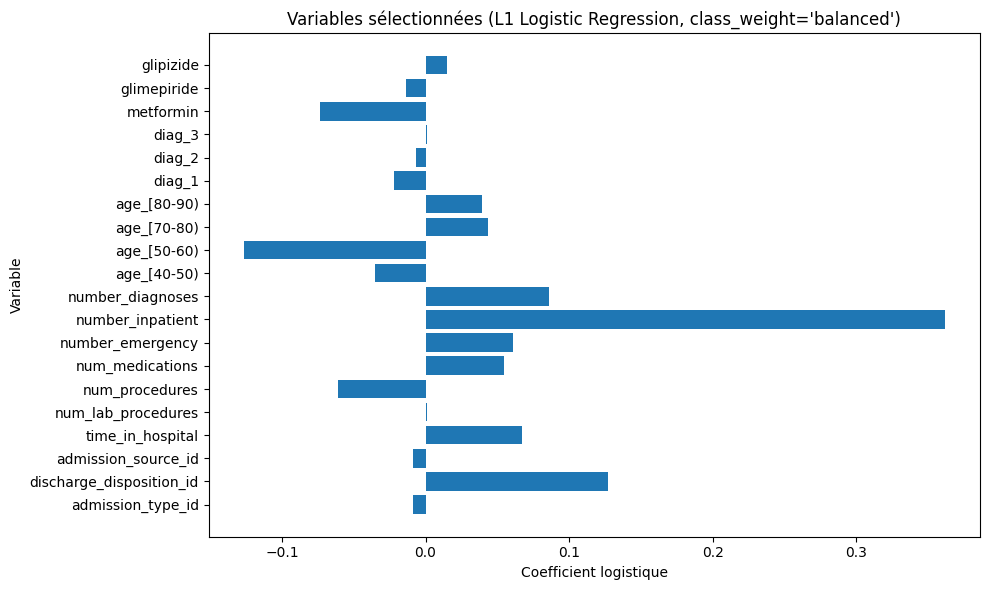

In [9]:
# Récupérer le modèle L1
model = lasso_pipeline.named_steps["feature_selection"].estimator_
coefs = model.coef_.flatten()

# Noms des variables
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f"x{i}" for i in range(X.shape[1])]
selected_features = np.array(feature_names)[coefs != 0]
selected_coefs = coefs[coefs != 0]

# Visualisation
plt.figure(figsize=(10,6))
plt.barh(selected_features, selected_coefs)
plt.title("Variables sélectionnées (L1 Logistic Regression, class_weight='balanced')")
plt.xlabel("Coefficient logistique")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


In [12]:
# --- Charger ton X complet si besoin ---
# (si X est déjà en mémoire, tu peux sauter cette ligne)
X_full = pd.read_csv("data/X_final.csv")

# --- Créer la base réduite avec uniquement les variables retenues ---
X_selected = X_full[selected_features]

# --- Enregistrer dans /data ---
output_path = os.path.join("data", "X_final_selected.csv")
X_selected.to_csv(output_path, index=False, encoding="utf-8")

print(f"✅ Base réduite enregistrée : {output_path}")
print(f"   → {X_selected.shape[0]} lignes et {X_selected.shape[1]} variables conservées")


✅ Base réduite enregistrée : data/X_final_selected.csv
   → 98053 lignes et 20 variables conservées
